In [168]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,roc_curve
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from time import time

from scipy.stats import randint
import random

from warnings import simplefilter
simplefilter("ignore")

In [2]:
bank_data = pd.read_csv('bank-additional-full.csv', sep=';')
print(bank_data.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [3]:
print(bank_data.shape)

(41188, 21)


In [4]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
bank_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


The age range in the dataset spans from 17 to 98 years with an average of 40 years.


The age distribution of clients have majority in the working class spaning from 32 to 47 years in age, while there seem to be fewer pensioneers or clients above 60 years.

The campaign calls distribution ranges from 1 to 56 calls per client including previous calls with an average approximately 3 calls per client.

Economic features such as consumer confidence index(cons.conf.idx), consumer price index(cons.price.inx) and employment variation rate (emp.var.rate)
show periods of recession and low consumer confidence

In [11]:
for col in bank_data.columns:
    if bank_data[col].dtype == 'object':
        print(f"{col}: {bank_data[col].value_counts().get('unknown', 0)}")


job: 330
marital: 80
education: 1731
default: 8597
housing: 990
loan: 990
contact: 0
month: 0
day_of_week: 0
poutcome: 0
y: 0


the distribution of unknown values in the attribute data of client is treated as null values

In [13]:
bank_data['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [14]:
bank_data['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [15]:
bank_data['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [16]:
bank_data['default'].unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [17]:
bank_data['housing'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [18]:
bank_data['loan'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [19]:
bank_data['contact'].unique()

array(['telephone', 'cellular'], dtype=object)

In [20]:
bank_data['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

In [21]:
bank_data['day_of_week'].unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

In [22]:
bank_data['poutcome'].unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [23]:
bank_data['y'].unique()

array(['no', 'yes'], dtype=object)

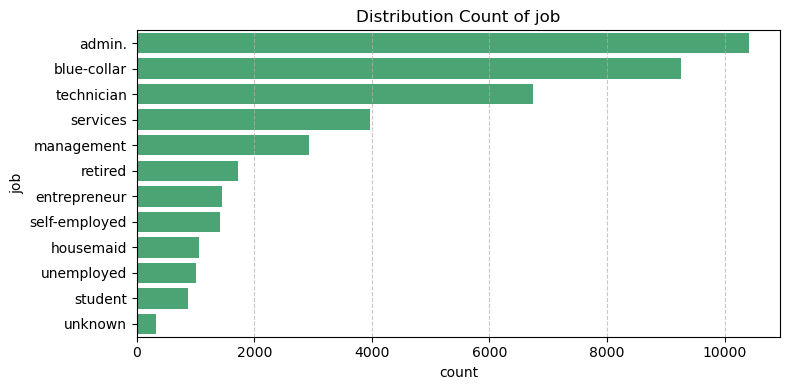

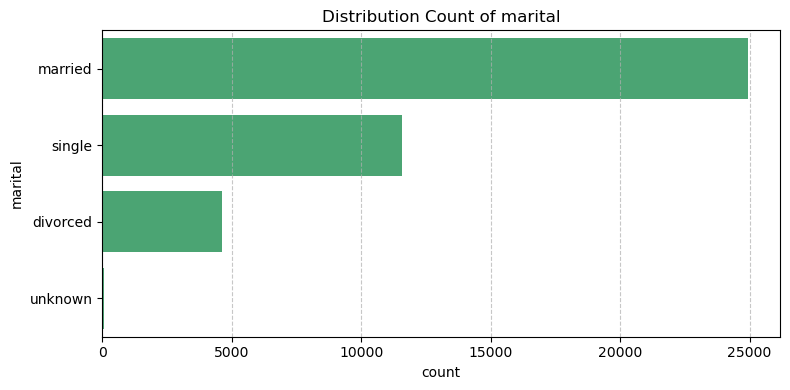

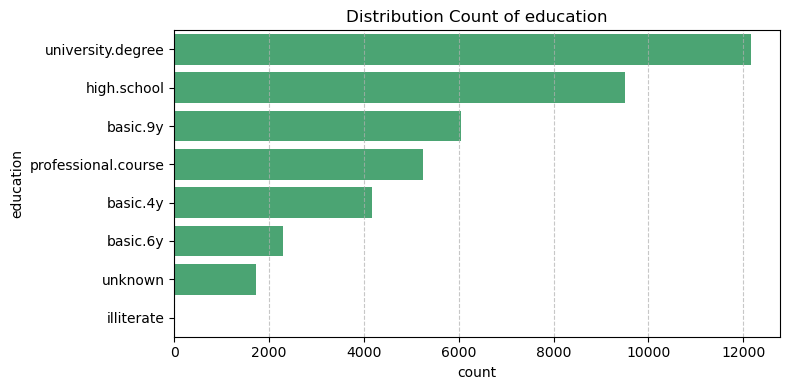

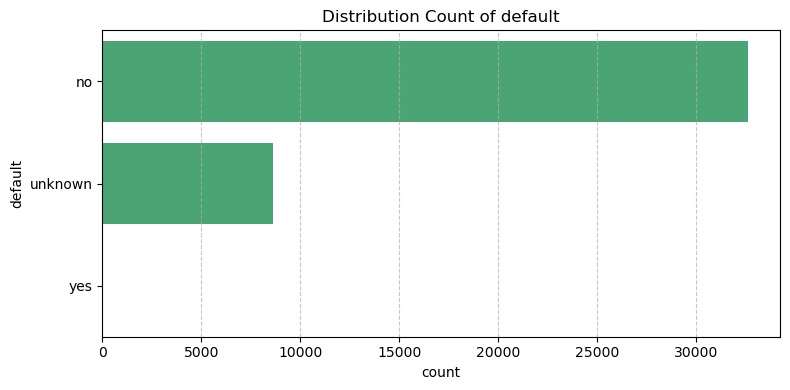

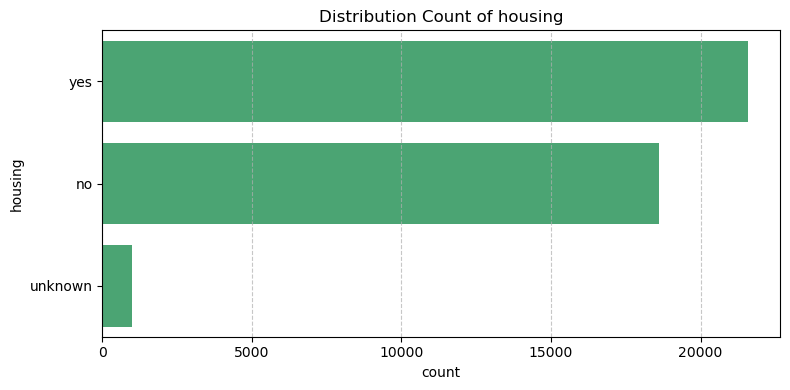

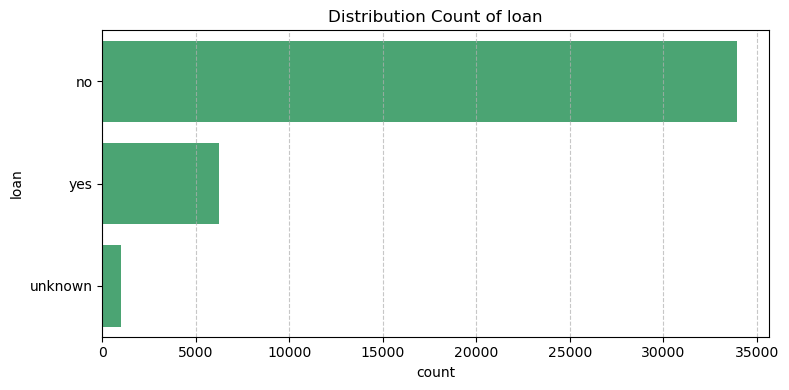

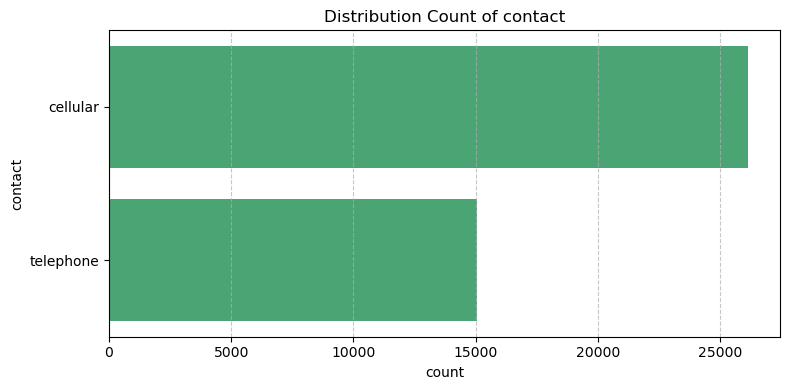

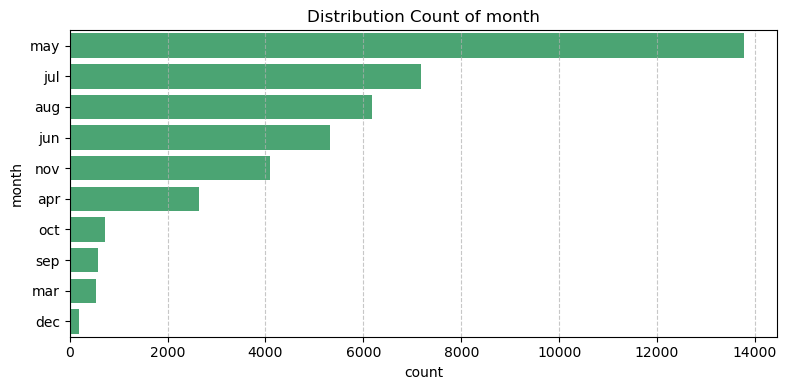

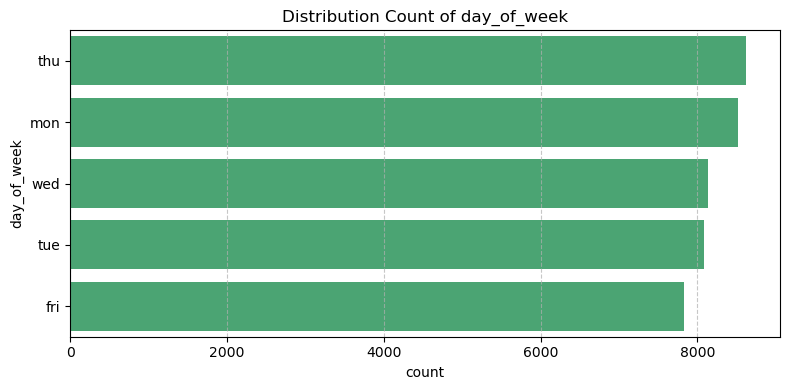

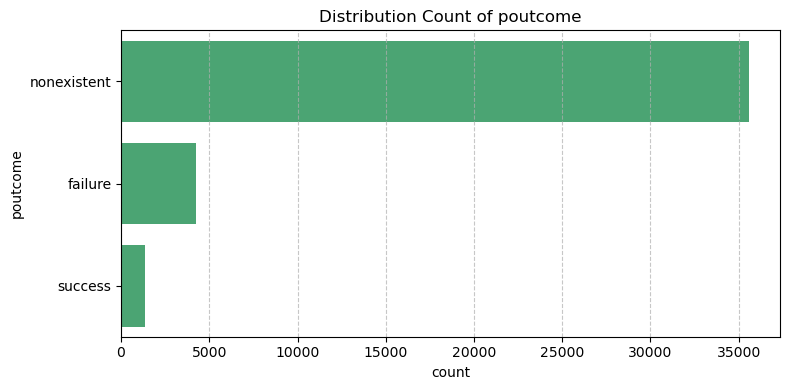

In [24]:
subscription_category = bank_data.select_dtypes(include='object').columns.drop('y')

for col in subscription_category:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=bank_data, y=col, order=bank_data[col].value_counts().index, color= 'mediumseagreen')
    plt.title(f"Distribution Count of {col}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


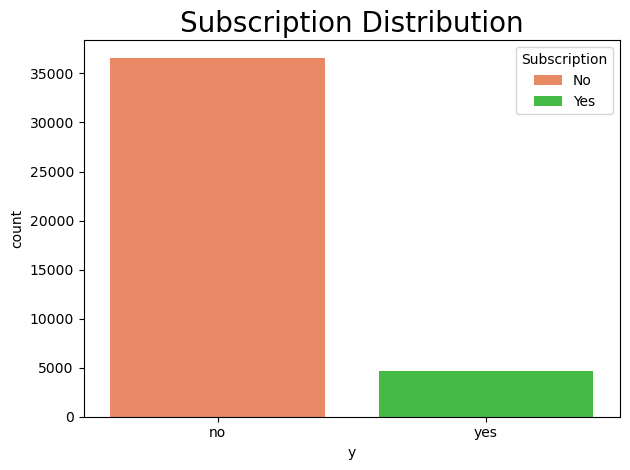

In [25]:
sns.countplot(data=bank_data, x='y', hue='y', palette={'yes': 'limegreen', 'no': 'coral'})

plt.title('Subscription Distribution', size=20)
plt.legend(title='Subscription', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


## Variable Distribution

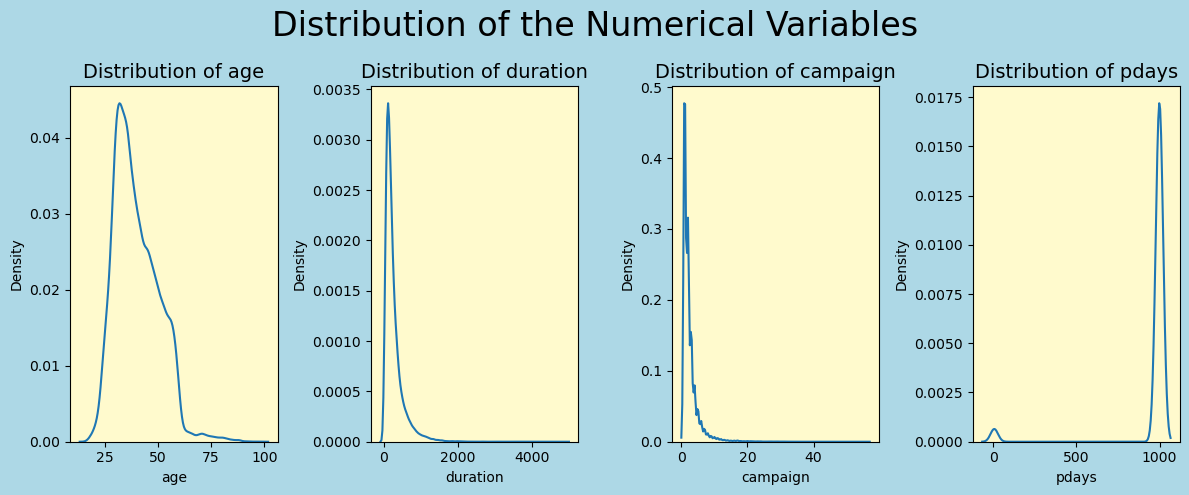

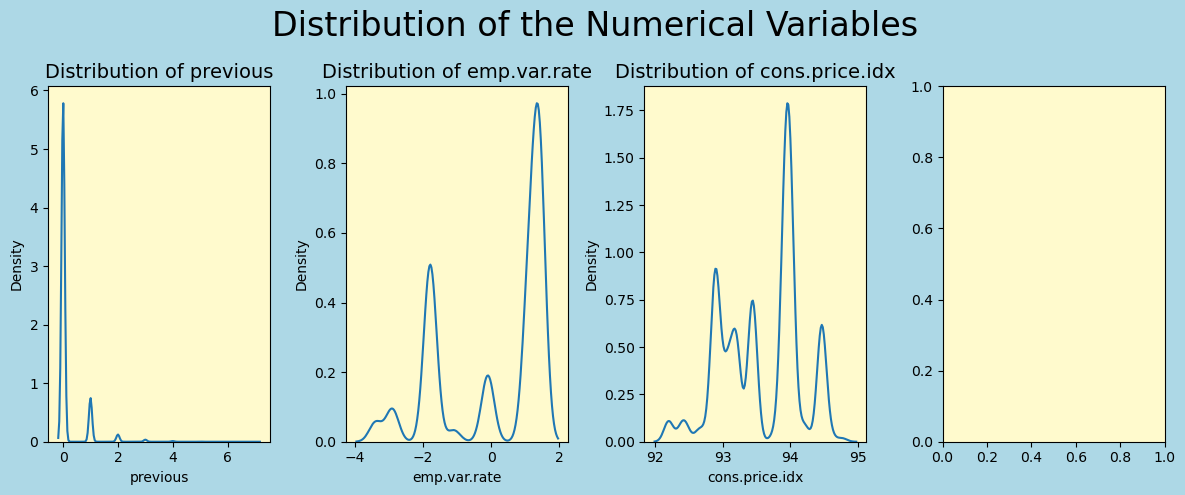

In [27]:
features = ['age','duration','campaign','pdays','previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

for i in range(2):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.distplot(bank_data[features[i*4]],ax=ax1,hist=False)
    ax1.set_title('Distribution of '+str(features[i*4]),fontsize=14)
    ax1.set_facecolor('lemonchiffon')
    ax2 = sns.distplot(bank_data[features[i*4+1]],ax=ax2,hist=False)
    ax2.set_title('Distribution of '+str(features[i*4+1]),fontsize=14)
    ax2.set_facecolor('lemonchiffon')
    ax3 = sns.distplot(bank_data[features[i*4+2]],ax=ax3,hist=False)
    ax3.set_title('Distribution of '+str(features[i*4+2]),fontsize=14)
    ax3.set_facecolor('lemonchiffon')
    if i < 1: 
        ax4 = sns.distplot(bank_data[features[i*4+3]],ax=ax4,hist=False)
        ax4.set_title('Distribution of '+str(features[i*4+3]),fontsize=14)
        ax4.set_facecolor('lemonchiffon')
    else:
        ax4.set_facecolor('lemonchiffon')
        
    fig.suptitle("Distribution of the Numerical Variables",fontsize=24)    
    
    plt.tight_layout()
    fig.set_facecolor('lightblue')

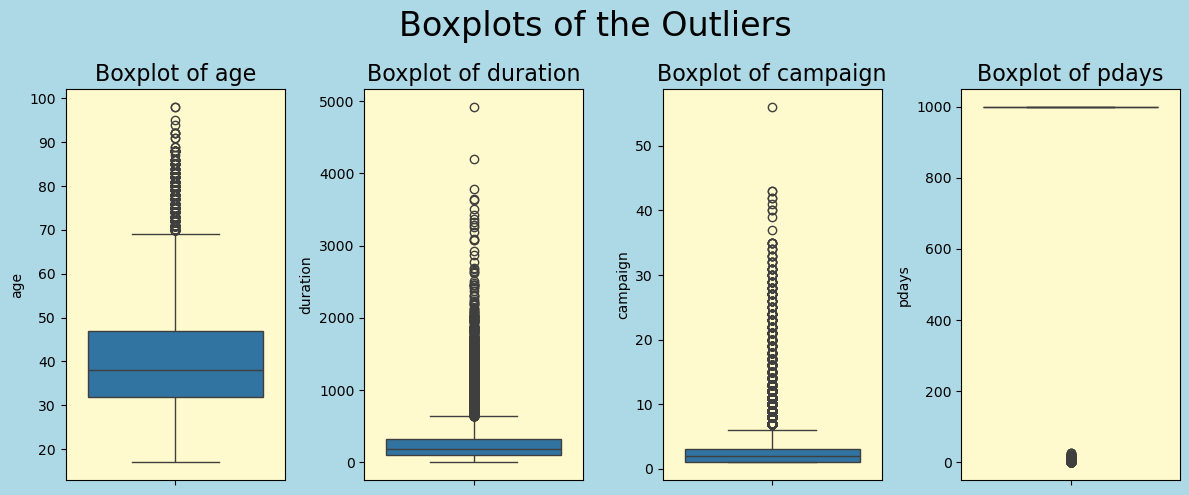

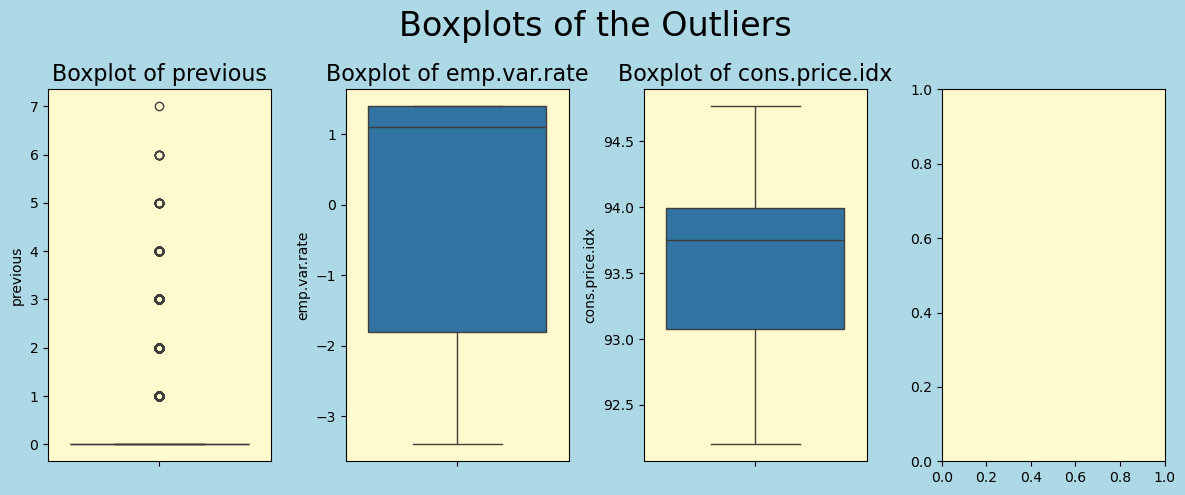

In [28]:
for i in range(2):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.boxplot(bank_data[features[i*4]],ax=ax1)
    ax1.set_title('Boxplot of '+str(features[i*4]),fontsize=16)
    ax1.set_facecolor('lemonchiffon')
    ax2 = sns.boxplot(bank_data[features[i*4+1]],ax=ax2)
    ax2.set_title('Boxplot of '+str(features[i*4+1]),fontsize=16)
    ax2.set_facecolor('lemonchiffon')
    ax3 = sns.boxplot(bank_data[features[i*4+2]],ax=ax3)
    ax3.set_title('Boxplot of '+str(features[i*4+2]),fontsize=16)
    ax3.set_facecolor('lemonchiffon')
    if i < 1: 
        ax4 = sns.boxplot(bank_data[features[i*4+3]],ax=ax4)
        ax4.set_title('Boxplot of '+str(features[i*4+3]),fontsize=16)
        ax4.set_facecolor('lemonchiffon')
    else:
        ax4.set_facecolor('lemonchiffon')
    
    fig.suptitle("Boxplots of the Outliers",fontsize=24)    
    
    plt.tight_layout()
    fig.set_facecolor('lightblue')

In [29]:
outliers_perc = []

for k,v in bank_data.items():
    # Column must be of numeric type (not object)
    if bank_data[k].dtype != 'O':
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(bank_data)[0]
        out_tuple = (k,int(perc))
        outliers_perc.append(out_tuple)
        print("Column %s outliers = %.2f%%" % (k,perc))

Column age outliers = 1.14%
Column duration outliers = 7.19%
Column campaign outliers = 8.22%
Column pdays outliers = 100.00%
Column previous outliers = 100.00%
Column emp.var.rate outliers = 0.00%
Column cons.price.idx outliers = 0.00%
Column cons.conf.idx outliers = 1.09%
Column euribor3m outliers = 0.00%
Column nr.employed outliers = 0.00%


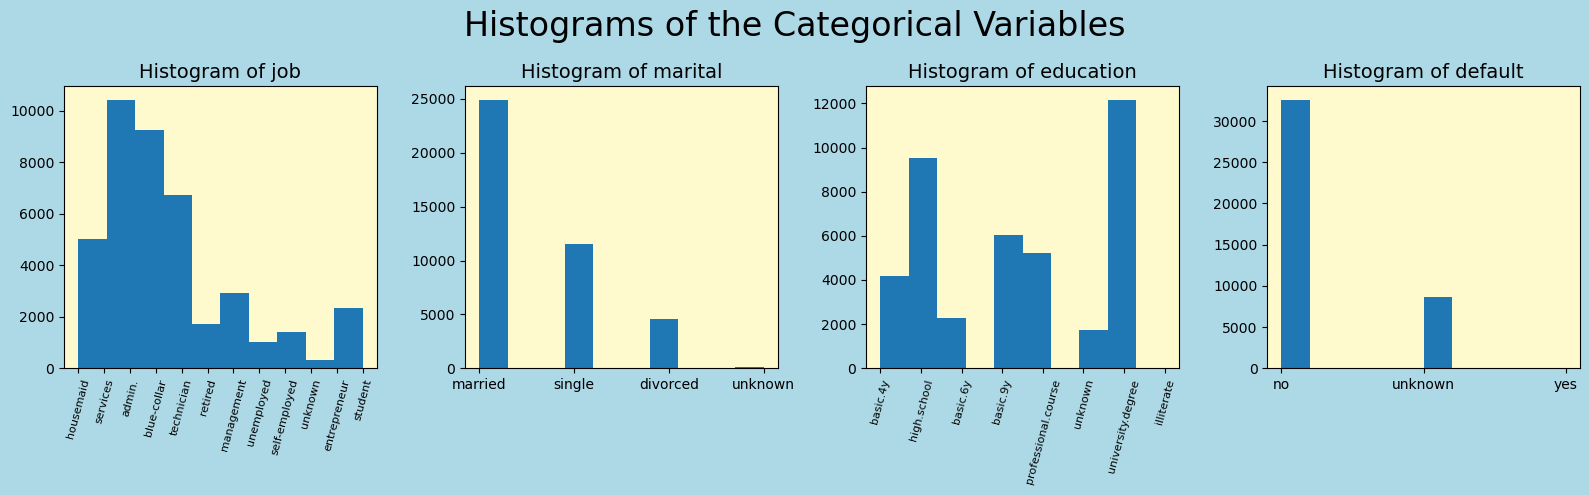

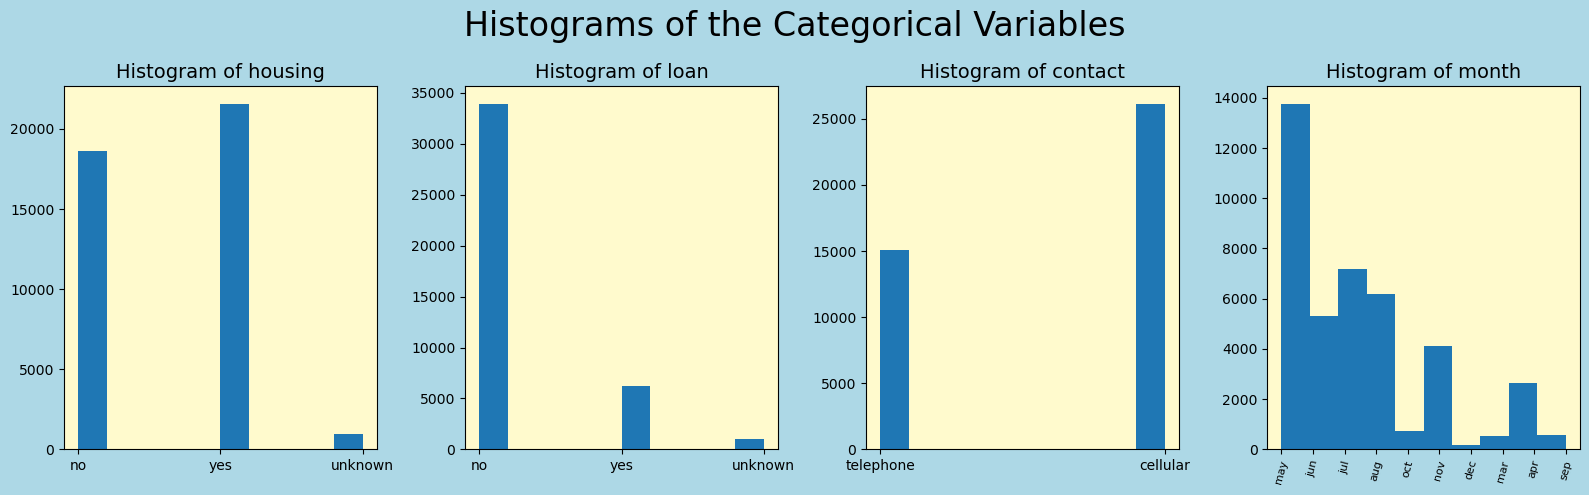

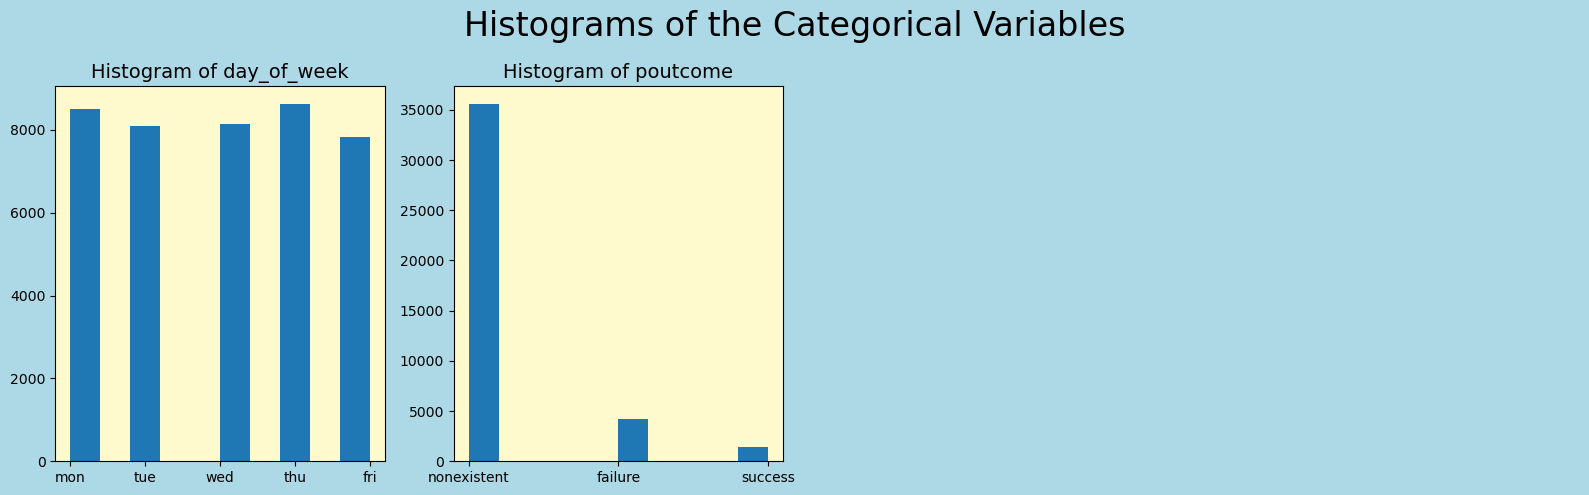

In [30]:
features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','day_of_week', 'poutcome']

for i in range(0, len(features), 4):
    batch = features[i:i+4]
    num_plots = len(batch)

    fig, axes = plt.subplots(ncols=4, figsize=(16, 5))
    fig.suptitle("Histograms of the Categorical Variables", fontsize=24)
    fig.set_facecolor('lightblue')

    for j in range(4):
        ax = axes[j]

        if j < num_plots:
            feature = batch[j]
            ax.hist(bank_data[feature])
            ax.set_title(f"Histogram of {feature}", fontsize=14)
            ax.set_facecolor('lemonchiffon')
            if bank_data[feature].nunique() > 5:
                ax.set_xticklabels(ax.get_xticklabels(), rotation=75, fontsize=8)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


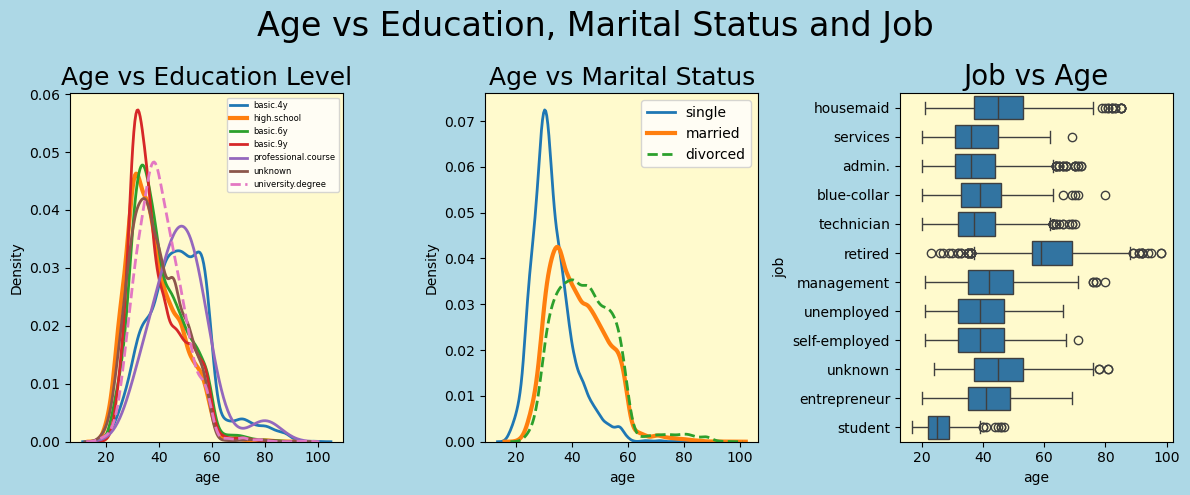

In [31]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

ax1 = sns.distplot(bank_data[bank_data['education'] == 'basic.4y']['age'],hist=False,ax=ax1,kde_kws={'linewidth':2})
ax1 = sns.distplot(bank_data[bank_data['education'] == 'high.school']['age'],hist=False,ax=ax1,kde_kws={'linewidth':3})
ax1 = sns.distplot(bank_data[bank_data['education'] == 'professional.course']['age'],hist=False,ax=ax1,kde_kws={'linewidth':2})
ax1 = sns.distplot(bank_data[bank_data['education'] == 'university.degree']['age'],hist=False,ax=ax1,kde_kws={'linewidth':2})
ax1 = sns.distplot(bank_data[bank_data['education'] == 'illiterate']['age'],hist=False,ax=ax1,kde_kws={'linewidth':2})
ax1 = sns.distplot(bank_data[bank_data['education'] == 'basic.9y']['age'],hist=False,ax=ax1,kde_kws={'linewidth':2})
ax1 = sns.distplot(bank_data[bank_data['education'] == 'basic.6y']['age'],hist=False,ax=ax1,kde_kws={'linestyle':'--','linewidth':2})
ax1.set_title('Age vs Education Level',fontsize=18)
ax1.legend(labels=['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree','illiterate'], prop={'size': 6})
ax1.set_facecolor('lemonchiffon')

ax2 = sns.distplot(bank_data[bank_data['marital'] == 'single']['age'],hist=False,ax=ax2,kde_kws={'linewidth':2})
ax2 = sns.distplot(bank_data[bank_data['marital'] == 'married']['age'],hist=False,ax=ax2,kde_kws={'linewidth':3})
ax2 = sns.distplot(bank_data[bank_data['marital'] == 'divorced']['age'],hist=False,ax=ax2,kde_kws={'linestyle':'--','linewidth':2})
ax2.set_title('Age vs Marital Status',fontsize=18)
ax2.legend(labels=['single','married','divorced'])
ax2.set_facecolor('lemonchiffon')

ax3 = sns.boxplot(bank_data,x='age',y='job',ax=ax3)
ax3.set_title("Job vs Age",fontsize=20)
ax3.set_facecolor('lemonchiffon')

fig.suptitle("Age vs Education, Marital Status and Job",fontsize=24) 

plt.tight_layout()
fig.set_facecolor('lightblue')

- Older consumers typically have primary education, whereas younger clients typically have secondary or tertiary education. 

- The youngest clients are typically single, and although divorcees tend to be slightly older, the distributions of married and divorced clients are not very different.
- 
- Lastly, the youngest clientele are typically students, while the oldest are retirees.

In [33]:
bank_data['y_binary'] = bank_data['y'].map({'yes': 1, 'no': 0})
print(bank_data['y_binary'])

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y_binary, Length: 41188, dtype: int64


#### Age Clusters

In [35]:
bank_data.loc[bank_data['age'] <= 25, 'age cluster'] = 'age <= 25'
bank_data.loc[(bank_data['age'] > 25) & (bank_data['age'] <= 35), 'age cluster'] = '25 < age <= 35'
bank_data.loc[(bank_data['age'] > 35) & (bank_data['age'] <= 45), 'age cluster'] = '35 < age <= 45'
bank_data.loc[(bank_data['age'] > 45) & (bank_data['age'] <= 55), 'age cluster'] = '45 < age <= 55'
bank_data.loc[(bank_data['age'] > 55) & (bank_data['age'] <= 65), 'age cluster'] = '55 < age <= 65'
bank_data.loc[bank_data['age'] > 65, 'age cluster'] = 'age > 65'


age_groups = bank_data.groupby('age cluster',as_index=False)['y_binary'].median().sort_values(by=['y_binary'],ascending=False)

In [36]:
default_yes = bank_data[bank_data['default'] == 'yes'].groupby('age cluster')['default'].value_counts().reset_index(name='count yes')

default_no = bank_data[bank_data['default'] == 'no'].groupby('age cluster')['default'].value_counts().reset_index(name='count no')

default_yes_perc = default_yes.merge(default_no,on='age cluster')

default_yes_perc['default percentage'] = (default_yes_perc['count yes'] / (default_yes_perc['count yes'] + default_yes_perc['count no'])) * 100

default_yes_perc.drop(['default_x','default_y','count yes','count no'],axis=1,inplace=True)

default_yes_perc = default_yes_perc.sort_values(by='default percentage',ascending=False)

In [37]:
loan_yes = bank_data[bank_data['loan'] == 'yes'].groupby('age cluster')['loan'].value_counts().reset_index(name='count yes')

loan_no = bank_data[bank_data['loan'] == 'no'].groupby('age cluster')['loan'].value_counts().reset_index(name='count no')

loan_yes_perc = loan_yes.merge(loan_no,on='age cluster')

loan_yes_perc['loan percentage'] = loan_yes_perc['count yes'] / (loan_yes_perc['count yes'] + loan_yes_perc['count no']) * 100

loan_yes_perc.drop(['loan_x','loan_y','count yes','count no'],axis=1,inplace=True)

loan_yes_perc = loan_yes_perc.sort_values(by='loan percentage',ascending=False)

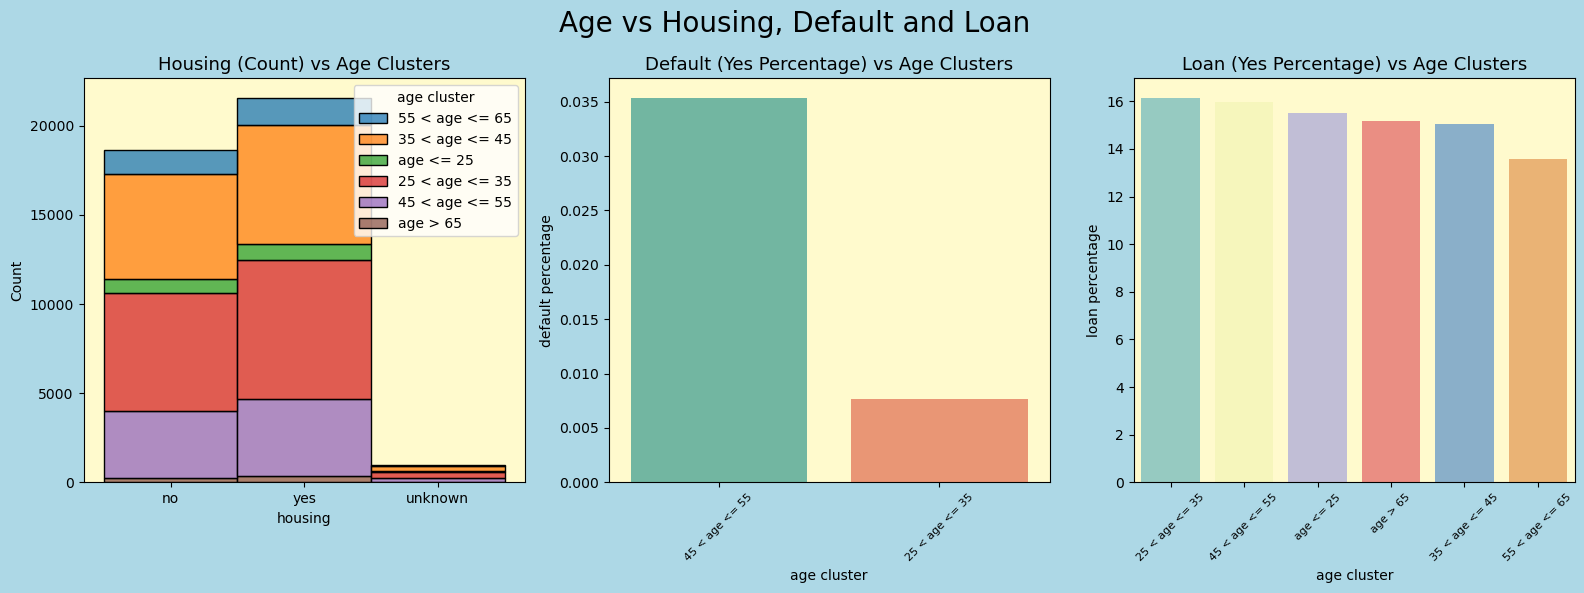

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 6))

ax1 = sns.histplot(data=bank_data, x='housing', multiple='stack', hue='age cluster', ax=ax1)
ax1.set_title('Housing (Count) vs Age Clusters', fontsize=13)
ax1.set_facecolor('lemonchiffon')

ax2 = sns.barplot(data=default_yes_perc, x='age cluster', y='default percentage', ax=ax2, palette='Set2')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)
ax2.set_title('Default (Yes Percentage) vs Age Clusters', fontsize=13)
ax2.set_facecolor('lemonchiffon')

ax3 = sns.barplot(data=loan_yes_perc, x='age cluster', y='loan percentage', ax=ax3, palette='Set3')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=8)
ax3.set_title('Loan (Yes Percentage) vs Age Clusters', fontsize=13)
ax3.set_facecolor('lemonchiffon')

fig.suptitle("Age vs Housing, Default and Loan", fontsize=20)
fig.set_facecolor('lightblue')
plt.tight_layout()
plt.show()


- Age groups like 25 < age ≤ 35 and 35 < age ≤ 45 appear to dominate both housing categories.
- 45 < age ≤ 55 has the highest default percentage, while 25 < age ≤ 35 has a lower rate.
- The 25 < age ≤ 35 group has the highest percentage of loans.The 55 < age ≤ 65 group has the lowest percentage of loans.



Marital Status vs Education

In [76]:
bank_data['education'] = bank_data['education'].str.strip().str.lower()
filtered_data = bank_data[bank_data['education'] != 'unknown'].copy()

filtered_data['marital'] = filtered_data['marital'].str.strip().str.lower()
filtered_data['marital_edu'] = filtered_data['marital'] + '+' + filtered_data['education']

marital_edu_groups = (
    filtered_data
    .groupby('marital_edu', as_index=False)['y_binary']
    .mean()
    .sort_values(by='y_binary', ascending=False)
)


### Cappin Outliers

In [90]:
def outlier_imputer(data,features):
    
    data_outlier = bank_data.copy()
    
    for column in features:        
        
        Q1 = (data_outlier[column].quantile(0.25)).astype(int)
        Q3 = (data_outlier[column].quantile(0.75)).astype(int)
        IQR = Q3 - Q1
        lowerL = (Q1 - 1.5 * IQR).astype(int)
        higherL = (Q3 + 1.5 * IQR).astype(int)
        
        data_outlier.loc[data_outlier[column] < lowerL,column] = lowerL
        data_outlier.loc[data_outlier[column] > higherL,column] = higherL
        
    return data_outlier 

features = ['age','duration','campaign','pdays','previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

capped_data = outlier_imputer(bank_data,features)  

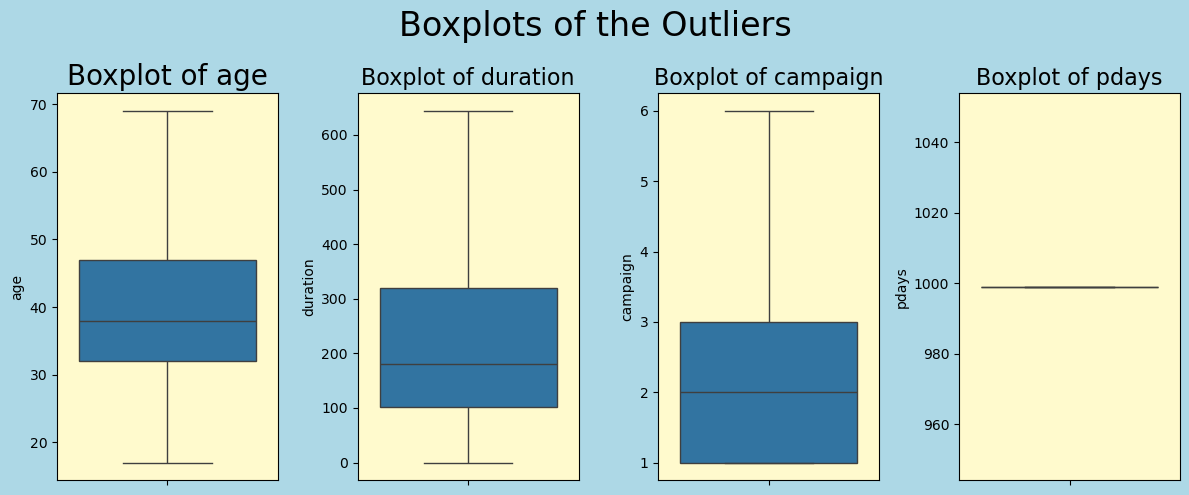

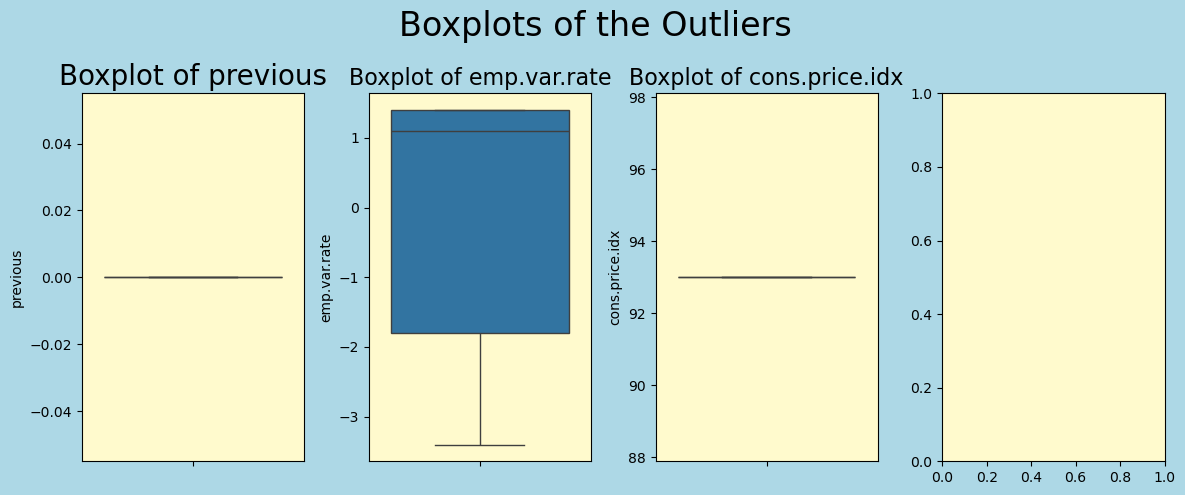

In [92]:
for i in range(2):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.boxplot(capped_data[features[i*4]],ax=ax1)
    ax1.set_title('Boxplot of '+str(features[i*4]),fontsize=20)
    ax1.set_facecolor('lemonchiffon')
    ax2 = sns.boxplot(capped_data[features[i*4+1]],ax=ax2)
    ax2.set_title('Boxplot of '+str(features[i*4+1]),fontsize=16)
    ax2.set_facecolor('lemonchiffon')
    ax3 = sns.boxplot(capped_data[features[i*4+2]],ax=ax3)
    ax3.set_title('Boxplot of '+str(features[i*4+2]),fontsize=16)
    ax3.set_facecolor('lemonchiffon')
    if i < 1: 
        ax4 = sns.boxplot(capped_data[features[i*4+3]],ax=ax4)
        ax4.set_title('Boxplot of '+str(features[i*4+3]),fontsize=16)
        ax4.set_facecolor('lemonchiffon')
    else:
        ax4.set_facecolor('lemonchiffon')
    
    fig.suptitle("Boxplots of the Outliers",fontsize=24)    
    
    plt.tight_layout()
    fig.set_facecolor('lightblue')

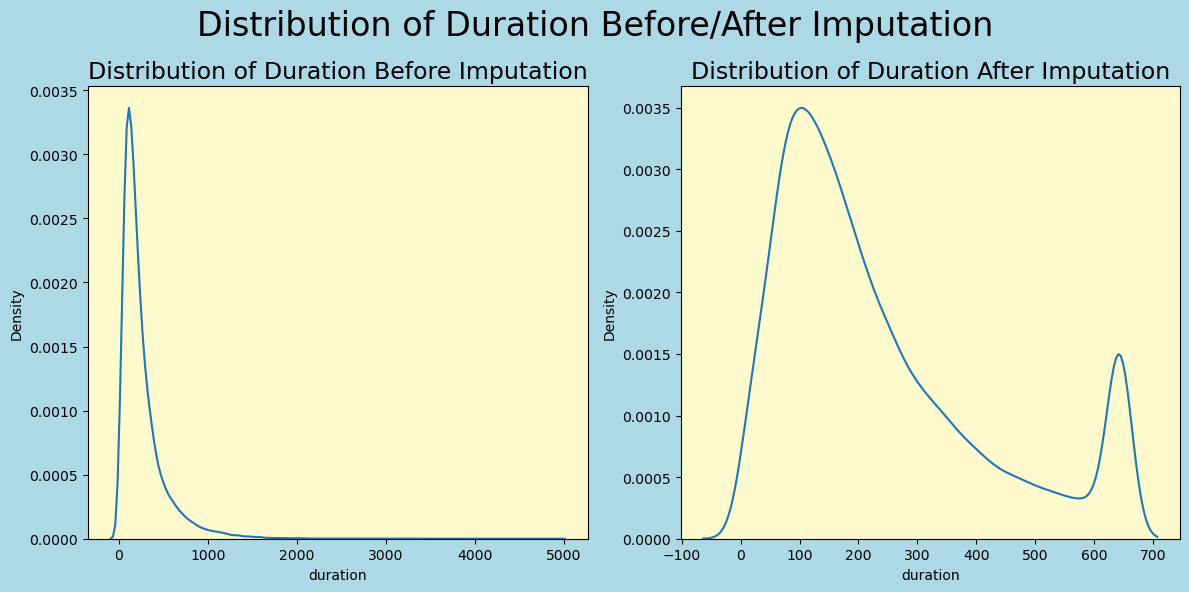

In [94]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.distplot(bank_data['duration'],ax=ax1,hist=False)
ax1.set_title('Distribution of Duration Before Imputation',fontsize=17)
ax1.set_facecolor('lemonchiffon')

ax2 = sns.distplot(capped_data['duration'],ax=ax2,hist=False)
ax2.set_title('Distribution of Duration After Imputation',fontsize=17)
ax2.set_facecolor('lemonchiffon')

fig.suptitle("Distribution of Duration Before/After Imputation",fontsize=24) 

plt.tight_layout()
fig.set_facecolor('lightblue')

after outliers imputation, the capped values have accomulated on the right-hand side of the distribution and have formed a second peak.

In [96]:
cleaned_data = capped_data.copy()

cat_cols = cleaned_data.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    cleaned_data = cleaned_data[~cleaned_data[col].str.lower().eq('unknown')]

cleaned_data.reset_index(drop=True, inplace=True)


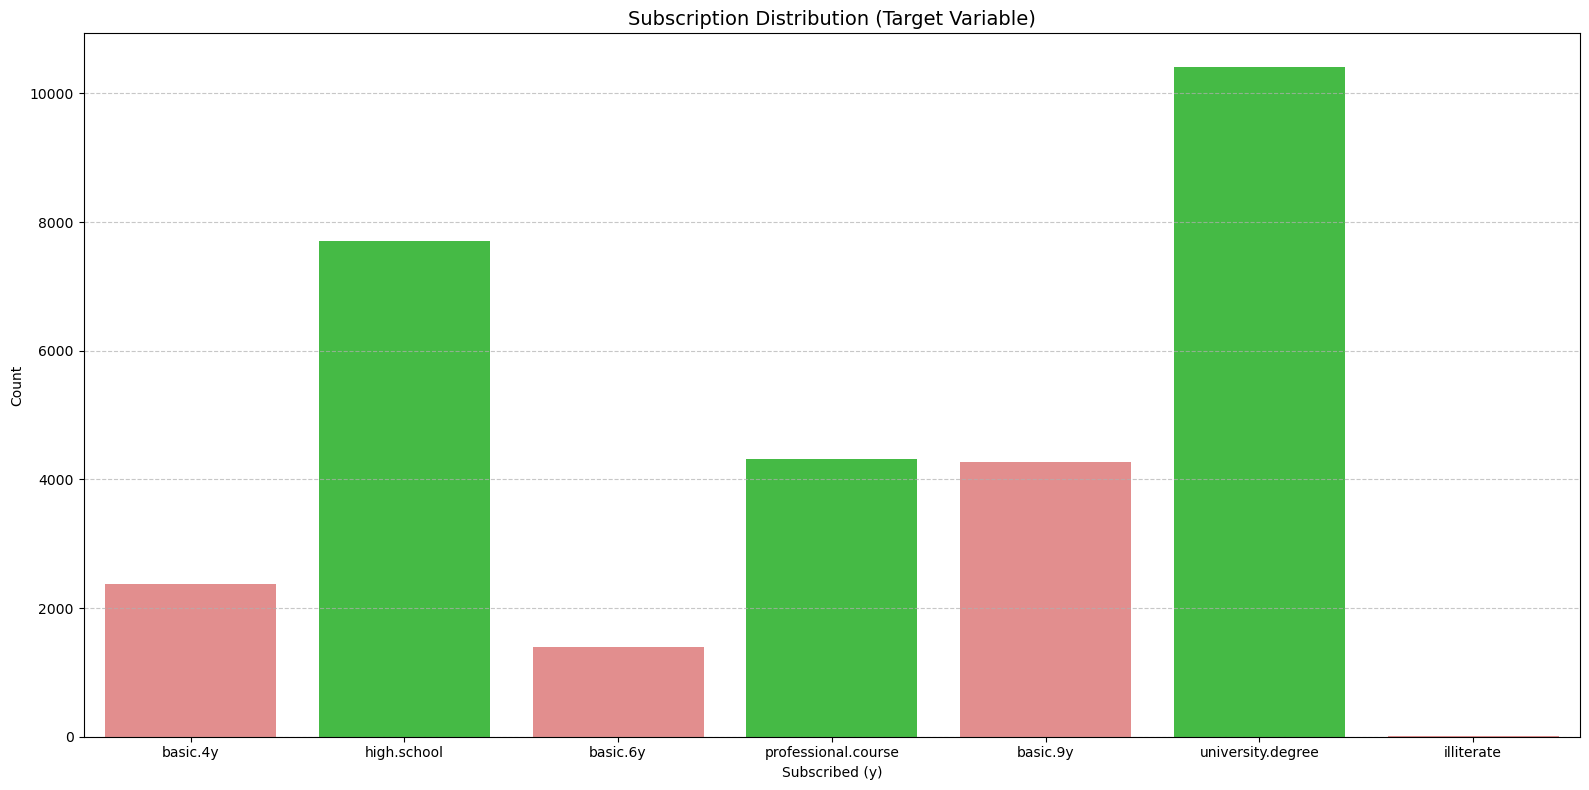

In [106]:
plt.figure(figsize=(16, 8))
sns.countplot(data=cleaned_data, x='education', palette=['lightcoral', 'limegreen'])
plt.title('Subscription Distribution (Target Variable)', fontsize=14)
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Building

In [126]:
##I cannot keep both 'age' and 'age cluster'; the same holds for 'marital' and 'education' vs 'marital_edu'. This is why I will have to drop some of them.

model_data = cleaned_data.drop(columns=['duration', 'education', 'marital', 'age cluster'])

X = model_data.drop(columns=['y', 'y_binary'])  
y = model_data['y_binary']

categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  
)



In [128]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'default', 'housing',
                                                   'loan', 'contact', 'month',
                                                   'day_of_week', 'poutcome',
                                                   'marital_edu'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      5326
           1       0.52      0.29      0.37       772

    accuracy                           0.88      6098
   macro avg       0.71      0.63      0.65      6098
weighted avg       0.86      0.88      0.86      6098



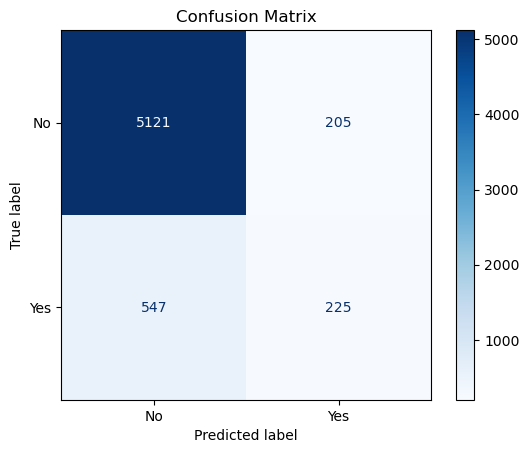

In [134]:

y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [136]:
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'poutcome'
]


📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5326
           1       0.62      0.25      0.35       772

    accuracy                           0.89      6098
   macro avg       0.76      0.61      0.64      6098
weighted avg       0.86      0.89      0.86      6098


📊 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      5326
           1       0.49      0.30      0.37       772

    accuracy                           0.87      6098
   macro avg       0.69      0.63      0.65      6098
weighted avg       0.85      0.87      0.86      6098



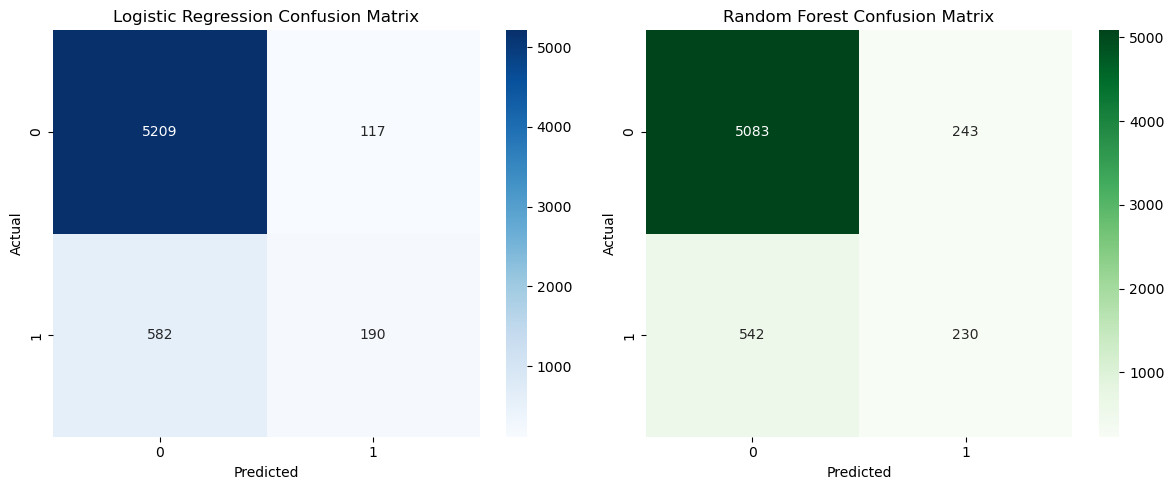

In [148]:
features_to_keep = [
    'age', 'job', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
    'poutcome', 'emp.var.rate', 'cons.price.idx',
    'cons.conf.idx', 'euribor3m', 'nr.employed'
]

X = cleaned_data[features_to_keep]
y = cleaned_data['y_binary']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

logreg_preds = logreg_pipeline.predict(X_test)
rf_preds = rf_pipeline.predict(X_test)

print("📊 Logistic Regression Classification Report:")
print(classification_report(y_test, logreg_preds))

print("\n📊 Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, logreg_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()



Logistic regression finds fewer positive cases (low recall: 25%), but is more confident when it does (62% precision).

Random Forest finds a few more positives (recall: 30%) but is less precise (49%).

In [162]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])


In [164]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}


In [166]:
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['job',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_we...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

In [170]:

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred))


Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      5326
           1       0.53      0.30      0.38       772

    accuracy                           0.88      6098
   macro avg       0.72      0.63      0.66      6098
weighted avg       0.86      0.88      0.86      6098



The model is excellent at predicting non-subscribers but struggles with predicting actual subscribers (positives).

Which is common in imbalanced classification problems.